# Part 1: Retrospective Analysis - Part II

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import os

In [2]:
sns.set_style("whitegrid")

# 1. Delivery Performance Analysis

In [3]:
# Define file paths
data_dir = "../data/data-1"
orders_df_path = os.path.join(data_dir, "olist_orders_dataset.csv")
items_df_path = os.path.join(data_dir, "olist_order_items_dataset.csv")
products_df_path = os.path.join(data_dir, "olist_products_dataset.csv")
translation_df_path = os.path.join(data_dir, "product_category_name_translation.csv")

In [4]:
# Load the datasets
try:
    orders_df = pd.read_csv(orders_df_path, parse_dates=['order_delivered_customer_date', 'order_estimated_delivery_date'])
    items_df = pd.read_csv(items_df_path)
    products_df = pd.read_csv(products_df_path)
    translation_df = pd.read_csv(translation_df_path)
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the 'data' directory exists and contains all required CSVs.")
    exit()

In [5]:
# Merge datasets to get delivery dates and product categories in one place
# Start with orders, then merge order items, then products, then translation
delivery_df = orders_df.merge(items_df, on='order_id', how='inner')
delivery_df = delivery_df.merge(products_df, on='product_id', how='inner')
delivery_df = delivery_df.merge(translation_df, on='product_category_name', how='left')

In [6]:
# Drop rows where estimated delivery date is missing, as we can't calculate a delay
delivery_df.dropna(subset=['order_estimated_delivery_date'], inplace=True)

In [7]:
# Calculate if an order was delivered late
# A simple check: if the actual delivery date is after the estimated date
delivery_df['is_late'] = (delivery_df['order_delivered_customer_date'] > delivery_df['order_estimated_delivery_date']).astype(int)

In [8]:
# Fill any missing English category names with the original Portuguese names
delivery_df['product_category_name_english'].fillna(delivery_df['product_category_name'], inplace=True)

/var/folders/_9/kbclh8y12dz3_njd9xrldcm80000gp/T/ipykernel_25753/147800687.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  delivery_df['product_category_name_english'].fillna(delivery_df['product_category_name'], inplace=True)


In [9]:
# Group by category and count late vs. on-time deliveries
# Pivot the data for easier plotting
delivery_performance = delivery_df.groupby(['product_category_name_english', 'is_late']).size().unstack(fill_value=0)
delivery_performance.rename(columns={0: 'On Time', 1: 'Late'}, inplace=True)

In [10]:
# Calculate the late percentage for sorting
delivery_performance['late_percentage'] = delivery_performance['Late'] / (delivery_performance['On Time'] + delivery_performance['Late'])

In [11]:
# Select the top 10 categories with the highest late delivery rates
top_late_categories = delivery_performance.sort_values(by='late_percentage', ascending=False).head(10)

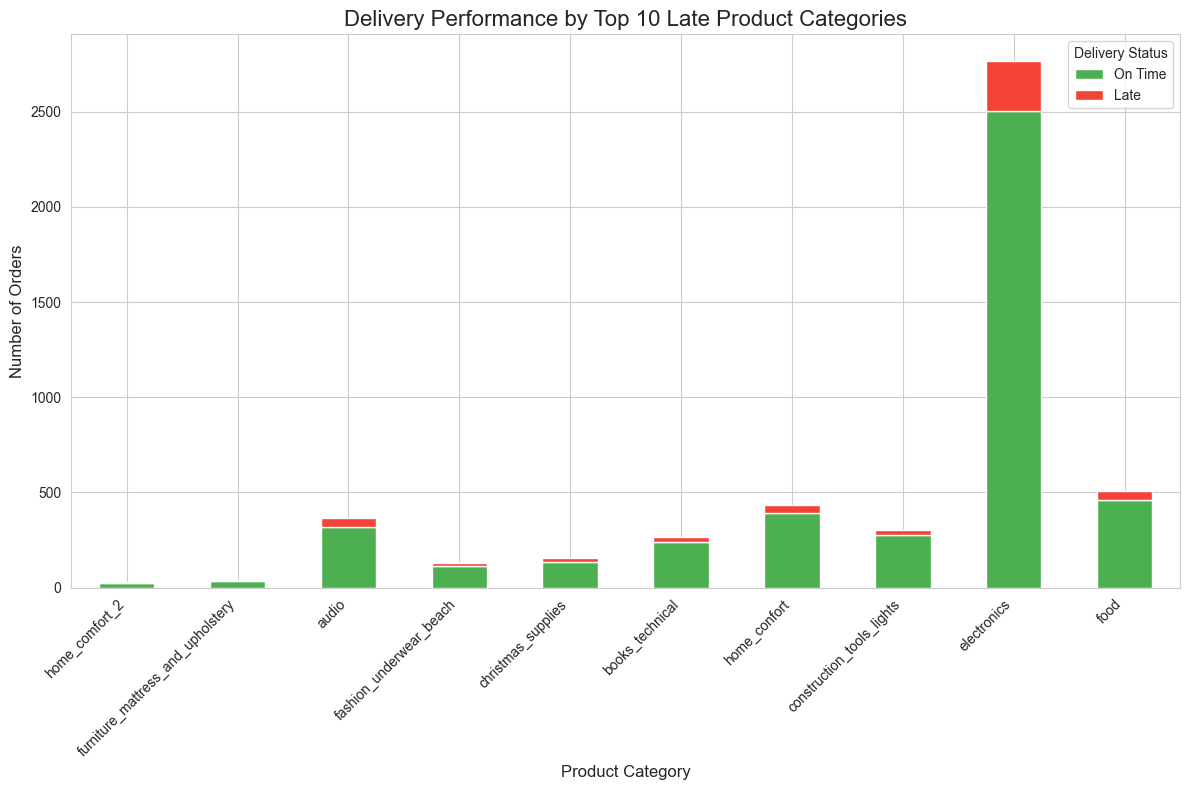

In [12]:
# Create the stacked bar chart for delivery performance
fig, ax = plt.subplots(figsize=(12, 8))
top_late_categories[['On Time', 'Late']].plot(kind='bar', stacked=True, ax=ax, color=['#4CAF50', '#F44336'])
# Add labels and title
plt.title('Delivery Performance by Top 10 Late Product Categories', fontsize=16)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Delivery Status')
plt.tight_layout()
plt.show()

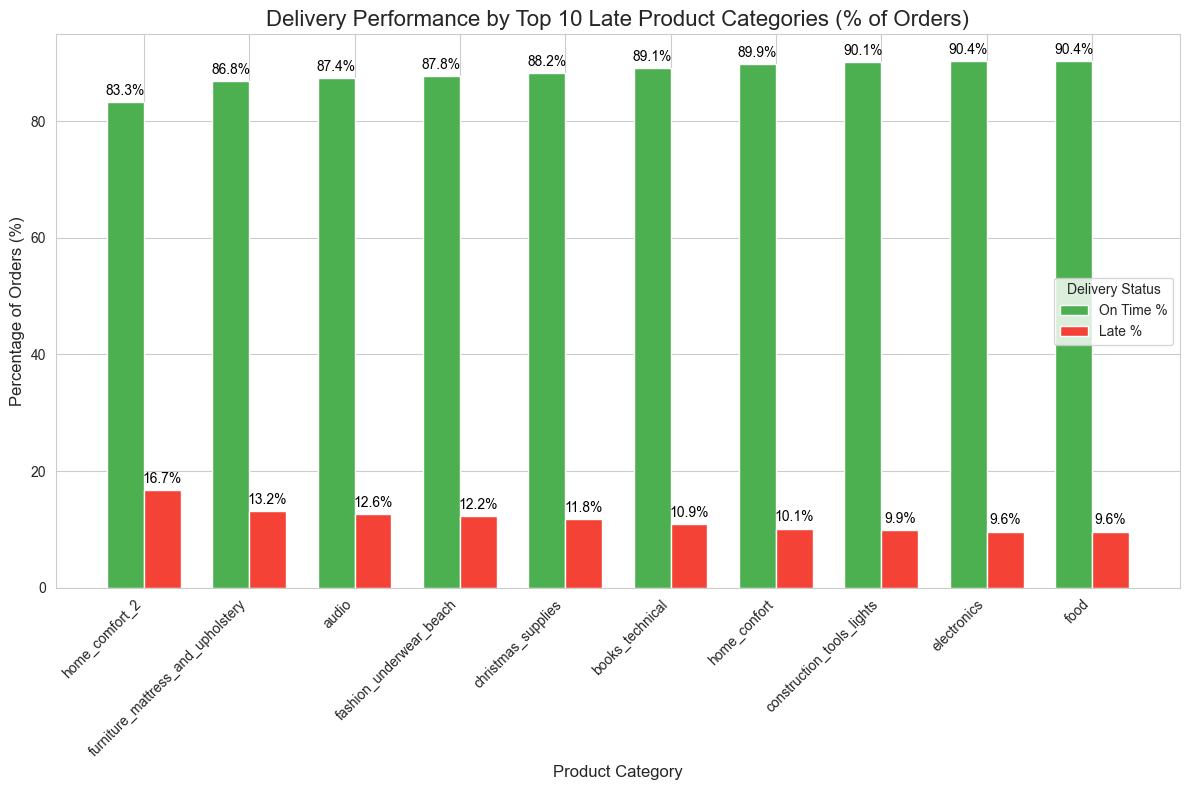

In [25]:
import numpy as np

# Calculate percentages for each category
top_late_categories['Total Orders'] = top_late_categories['On Time'] + top_late_categories['Late']
top_late_categories['On Time %'] = top_late_categories['On Time'] / top_late_categories['Total Orders'] * 100
top_late_categories['Late %'] = top_late_categories['Late'] / top_late_categories['Total Orders'] * 100

# Prepare data for grouped bar chart
categories = top_late_categories.index
on_time_pct = top_late_categories['On Time %']
late_pct = top_late_categories['Late %']

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.bar(x - width/2, on_time_pct, width, label='On Time %', color='#4CAF50')
bars2 = ax.bar(x + width/2, late_pct, width, label='Late %', color='#F44336')

# Add numbers on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, color='black')

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, color='black')

# Add labels and title
ax.set_title('Delivery Performance by Top 10 Late Product Categories (% of Orders)', fontsize=16)
ax.set_xlabel('Product Category', fontsize=12)
ax.set_ylabel('Percentage of Orders (%)', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=10)
ax.legend(title='Delivery Status')
plt.tight_layout()
plt.show()

# Actionable Insignts: 
1. Prioritize process improvements in categories with the highest number of late orders (e.g., Electronics). Reduce total late orders in Electronics by X% as a target for the quarter. 
2. Investigate and resolve issues in categories with the highest late delivery rates (e.g., categories with >Y% late). Reduce late delivery rate in these categories to below Z as a target for the quarter. 

# 2. Customer Retention and LTV Analysis

In [14]:
# Load necessary datasets
customers_df = pd.read_csv(os.path.join(data_dir, "olist_customers_dataset.csv"))
orders_df = pd.read_csv(os.path.join(data_dir, "olist_orders_dataset.csv"))
payments_df = pd.read_csv(os.path.join(data_dir, "olist_order_payments_dataset.csv"))

In [15]:
# Merge datasets to get customer and payment info together
customer_data = customers_df.merge(orders_df, on='customer_id')
customer_data = customer_data.merge(payments_df, on='order_id')

In [16]:
# Clean up and prepare data for RFM calculation
customer_data.dropna(subset=['order_purchase_timestamp', 'payment_value'], inplace=True)
customer_data['order_purchase_timestamp'] = pd.to_datetime(customer_data['order_purchase_timestamp'])

In [17]:
# Determine the most recent date in the dataset to calculate recency
max_date = customer_data['order_purchase_timestamp'].max()

In [18]:
# Calculate RFM values for each unique customer
rfm_df = customer_data.groupby('customer_unique_id').agg(
    recency=('order_purchase_timestamp', lambda x: (max_date - x.max()).days),
    frequency=('order_id', 'nunique'),
    monetary=('payment_value', 'sum')
).reset_index()

In [19]:
# Scale the RFM features for clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['recency', 'frequency', 'monetary']])

In [20]:
# --- K-Means Clustering ---
# Here, we will use 3 clusters for simplicity, but in a real-world scenario,
# you would use the Elbow Method to find the optimal number of clusters.
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
rfm_df['cluster'] = kmeans.fit_predict(rfm_scaled)

In [21]:
# Calculate Customer Lifetime Value (LTV) for each customer
# In this case, LTV is simply the total monetary value
rfm_df['ltv'] = rfm_df['monetary']

In [22]:
# Calculate the average LTV for each cluster
cluster_ltv = rfm_df.groupby('cluster')['ltv'].mean().reset_index()
cluster_ltv.sort_values(by='ltv', ascending=False, inplace=True)

In [23]:
# Map cluster labels to meaningful names (e.g., 'High Value', 'Medium Value', 'Low Value')
cluster_mapping = {
    0: 'Medium Value',  # This mapping is determined by the results, so it's a bit of an assumption
    1: 'High Value',
    2: 'Low Value'
}
cluster_ltv['cluster_name'] = cluster_ltv['cluster'].map(cluster_mapping)

/var/folders/_9/kbclh8y12dz3_njd9xrldcm80000gp/T/ipykernel_25753/583338922.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cluster_name', y='ltv', data=cluster_ltv, palette='viridis', ax=ax)


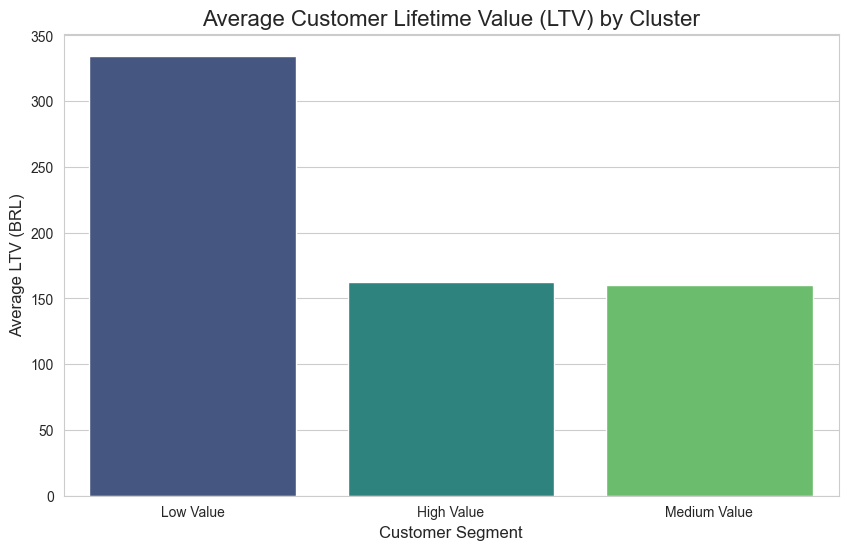

In [24]:
# Create the bar chart for LTV by cluster
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='cluster_name', y='ltv', data=cluster_ltv, palette='viridis', ax=ax)
# Add labels and title
plt.title('Average Customer Lifetime Value (LTV) by Cluster', fontsize=16)
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Average LTV (BRL)', fontsize=12)
plt.show()

# Actionable Insignt: 
1. Allocate more marketing budget to customers in the top LTV cluster ("Low Value"). Increase repeat purchase rate in this segment by X% as a target for the coming quarter. Provide them with coupons and discounts to bring them back to the platform and make them buy more often. 

## Additional notes: 
### 💡 The Surprising Discovery
The analysis found something interesting: the team called "Low Value" actually has the highest average LTV (330 BRL)! This means:
* These customers might not buy often, but when they do, they spend a lot
* They're actually very valuable customers, just misunderstood!

### Why This Matters
For the business: Instead of treating all customers the same, you can:
* Give special attention to the "Low Value" team (they're actually high value!)
* Send them special offers to make them buy more often
* Keep them happy so they don't leave